In [3]:
import torch
import os
import random
import numpy as np

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from dataset.utils import process_classification_dataset, load_classification_dataset

config = {
        'dataset': 'facebook_ct1', # 'infectious_ct1', #
        'hidden_size': 64,
        'rnn_layers': 5,
        'readout_layers': 1,
        'cell_type': 'lstm',
        'dim_red': 64,
        'add_self_loops': False,
        'verbose': True,
        'cat_states_layers': True,
        'weight_decay': 0,
        'step_size': 30,
        'gamma': 0.5,
        'testing': True,
        }

# Select one GPU if more are available
os.environ["CUDA_VISIBLE_DEVICES"]='0'

seed = 42
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# Fix cuda memory issue
dataset, states, node_states, node_labels = process_classification_dataset(config, "DynCRNN", device)

100%|██████████| 50/50 [00:43<00:00,  1.14it/s]


In [5]:
edge_indexes, _, _ = load_classification_dataset(config['dataset'], False)

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

inputs, test_inputs, labels, test_labels = train_test_split(states.inputs[:,-1,:], dataset.targets, test_size=0.2, random_state=seed)

# Create the classifier
classifier = LogisticRegression(max_iter=5000, random_state=seed)

# Train the classifier
classifier.fit(inputs, labels)

# Test the classifier
y_pred = classifier.predict(test_inputs)

accuracy = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 1.0


# PCA per node

In [22]:
from koopman.sindy import SINDy
from einops import rearrange

idx = 0

# Z = rearrange(node_states[idx], 't n f -> n t f')
Z = node_states[idx]
edge_index = edge_indexes[idx]
k = 10
alpha = 1.0
emb = "PCA"
degree = 3

sindy = SINDy(Z, edge_index, k, add_self_dependency=False, degree=degree, alpha=alpha, emb=emb)

In [23]:
sindy.library.shape

torch.Size([930, 106, 10])

In [24]:
K = sindy.fit()

In [27]:
K.shape

(1000, 9300)

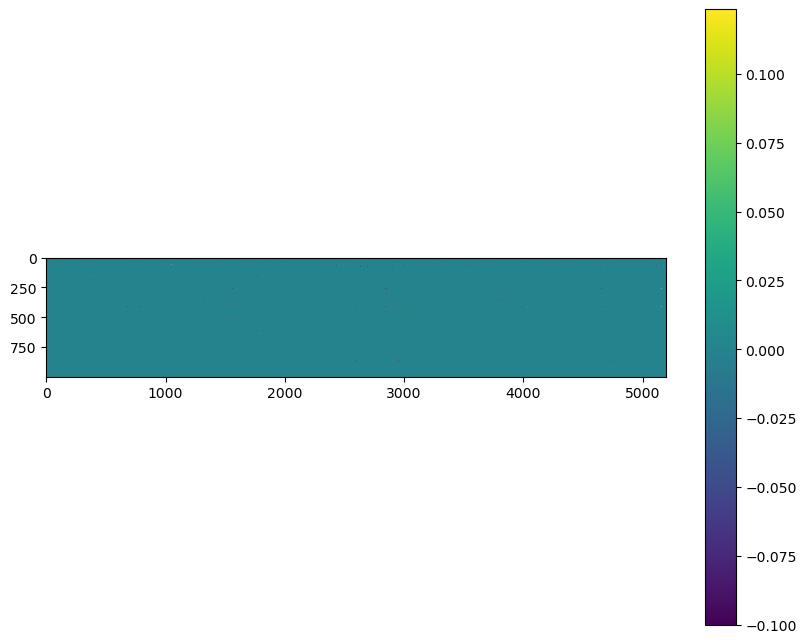

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(K[:,4100:], interpolation='nearest')
plt.colorbar()

Summing over the "F" dimension

In [39]:
# Remove "F" dimension
sum_K = K.reshape(-1, k, K.shape[1]).sum(axis=1)
sum_K = sum_K.reshape(sum_K.shape[0], -1, k).sum(axis=2)

In [40]:
sum_K.shape

(100, 930)

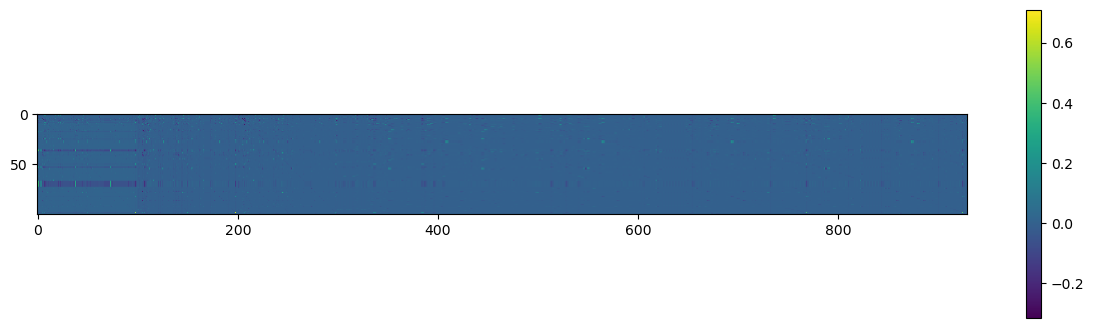

In [42]:
plt.figure(figsize=(15, 4))

plt.imshow(sum_K)
plt.colorbar()
plt.show()

In [45]:
weights = sindy.compute_weights()

In [46]:
weights.shape

(630,)

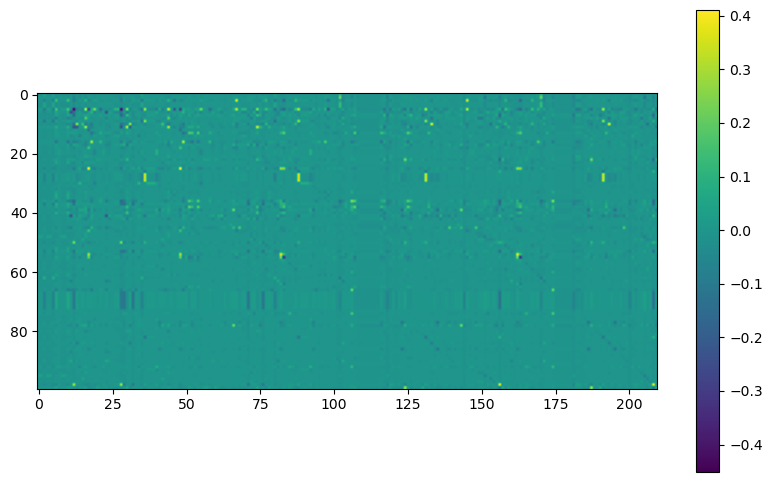

In [23]:
plt.figure(figsize=(10, 6))

plt.imshow(sum_K[:,200:])
plt.colorbar()
plt.show()

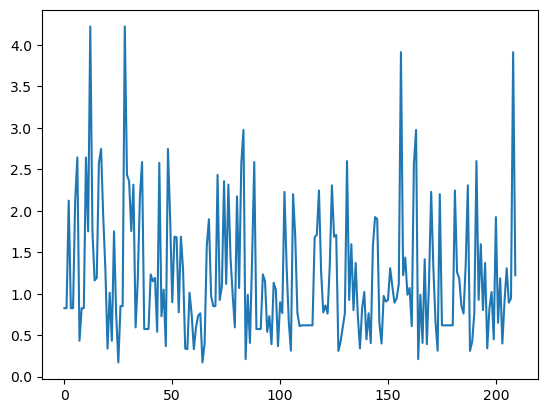

In [25]:
plt.plot(weights)

In [31]:
from dataset.utils import ground_truth

nodes_gt, node_sums_gt, times_gt, edges_gt = ground_truth("facebook_ct1")

995it [00:06, 147.39it/s]


In [ ]:
from utils.metrics import auc_analysis

num_nodes = node_states[idx].shape[0]
fig, auc = auc_analysis(weights, edge_index, edges_gt[idx], num_nodes, plot=True)

In [ ]:
plt.show()